In [1]:
import os
from PIL import Image
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from dataclasses import dataclass
from typing import List
import random
from torchvision import transforms
import numpy as np
from tqdm import tqdm

# -- To insert non functional code in the image to get augmented image --
class CodeInserter:
    def __init__(self, image: Image.Image):
        self.image = image
        self.flat_img = np.array(image).ravel()
        self.opcodes = [0, 144, 204, 205]
        self.patterns = [
            [0],              # Simulates null padding
            [144],            # Simulates single-byte NOP
            [204],            # Simulates debug breakpoint
            #[255],            # Simulates filler bytes
            [102, 144]        # Simulates 2-byte NOP (0x66 0x90)
        ]
    def _generate_random_slice(self, min_len=40, max_len=400):
        """
        Generates a slice of noise using one of several realistic strategies.
        """
        slice_length = random.randint(min_len, max_len)
        # Randomly choose a generation mode for this slice
        generation_mode = random.choice(['pattern', 'structured_noise'])
        if generation_mode == 'pattern':
            # --- Strategy 1: Repeat a specific, ordered pattern ---
            chosen_pattern = random.choice(self.patterns)
            num_repeats = (slice_length // len(chosen_pattern)) + 1# Tile the pattern until it's long enough
            tiled_pattern = np.tile(chosen_pattern, num_repeats)
            return tiled_pattern[:slice_length]# Trim to the exact slice_length
        else:
            # --- Strategy 2: Create a random mix of opcodes ---
            num_opcodes = random.randint(2, len(self.opcodes))
            chosen_opcodes = random.sample(self.opcodes, num_opcodes)
            return np.random.choice(chosen_opcodes, size=slice_length)
    def _calculate_new_dimensions(self, new_pixel_count: int):
        """
        Calculates new width and height, preserving aspect ratio.
        This is a simpler, more direct way to do the math.
        """
        og_w, og_h = self.image.size
        aspect_ratio = og_w / og_h
        new_h = int(np.sqrt(new_pixel_count / aspect_ratio))
        new_w = int(new_h * aspect_ratio)
        # Pad to ensure the new canvas is big enough
        while new_w * new_h < new_pixel_count:
            new_w += 1
        return new_w, new_h
    def augment(self):
        """
        Applies the insertion augmentation and returns a new PIL Image.
        """
        augmented_image = self.flat_img.copy()
        num_insertions = random.randint(1, 3)
        max_idx = len(augmented_image)
        cut_points = np.random.choice(max_idx, size=num_insertions, replace=False)
        cut_points.sort()
        for point in reversed(cut_points):
            insertion_slice = self._generate_random_slice()
            augmented_image = np.insert(augmented_image, point, insertion_slice)
        new_w, new_h = self._calculate_new_dimensions(len(augmented_image))
        pad_len = (new_w * new_h) - len(augmented_image)# pad the array to fit the new rectangular shape
        padded_image = np.pad(augmented_image, (0, pad_len), 'constant')
        reshaped_image = padded_image.reshape((new_h, new_w)).astype(np.uint8)
        final_image = Image.fromarray(reshaped_image) # construct PIL image
        #final_image.resize((64, 64), Image.Resampling.LANCZOS)
        return final_image.resize((64, 64), Image.Resampling.LANCZOS)

# -- To duplicate functional code in the image to get augmented image --
class CodeDuplicator:
    def __init__(self, image: Image.Image):
        self.image = image
        self.flat_img = np.array(image).ravel()
        self.img_height, self.img_width = image.height, image.width

    def _get_duplication_parameters(self):
        # Using a square patch with a side length between 8 and 20 pixels.
        side_length = random.randint(8, 20)
        #window = side_length * side_length
        window =int(0.1 * self.flat_img.size)  # 10 % of the input image size

        max_start = len(self.flat_img) - window
        start_point = random.randint(0, max_start)
        while True:
            insertion_point = random.randint(0, max_start)
            if abs(start_point - insertion_point) >= window:
                break # found valid
        return start_point, insertion_point, window

    def augment(self):
        """
        Applies the duplication augmentation and returns a new PIL Image.
        This is the main public method to call.
        """
        start, duplicate_at, window = self._get_duplication_parameters()
        augmented_flat = self.flat_img.copy()
        snippet = self.flat_img[start : start + window]
        augmented_flat[duplicate_at : duplicate_at + window] = snippet
        augmented_2d = np.reshape(augmented_flat, (self.img_height, self.img_width))
        return Image.fromarray(augmented_2d.astype(np.uint8))

# -- Sampling and creation of batches --
class TaskSampler:
    def __init__(self, resized_folder: str, families: list, meta_batch_size: int, n_way: int, k_shot: int, q_query: int):
        self.resized_folder = resized_folder
        self.families = families
        self.meta_batch_size = meta_batch_size
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        # Pre-load all image paths for efficiency
        self.image_paths_by_family = {
            f: [os.path.join(resized_folder, f, img_name) for img_name in os.listdir(os.path.join(resized_folder, f))]
            for f in self.families
        }
        # Define a single transform to convert PIL Images to PyTorch Tensors
        self.to_tensor = transforms.ToTensor() # output on using on one image is (1, H, W)
    def _create_input_tensor(self, base_img: Image.Image) -> torch.Tensor:
        """Creates the 3-channel tensor from a single PIL image."""
        # Instantiate your augmentation classes for each image
        aug1_img = CodeInserter(base_img).augment()
        aug2_img = CodeDuplicator(base_img).augment()
        base_tensor = self.to_tensor(base_img)
        aug1_tensor = self.to_tensor(aug1_img)
        aug2_tensor = self.to_tensor(aug2_img)
        # Note: to_tensor creates a (1, H, W) tensor, so we cat on dim 0
        #return torch.cat([base_tensor, base_tensor, base_tensor], dim=0)
        return torch.cat([base_tensor, aug1_tensor, aug2_tensor], dim=0)
    def sample(self):
        """
        Samples a full meta-batch of tasks.
        Returns:
            A tuple of (support_x, support_y, query_x, query_y) tensors.
        """
        support_x_batch, support_y_batch = [], []
        query_x_batch, query_y_batch = [], []

        for _ in range(self.meta_batch_size):
            support_x, support_y = [], []
            query_x, query_y = [], []
            task_families = random.sample(self.families, self.n_way) # has the names of the families present in this task

            for i, family in enumerate(task_families):
                all_paths = self.image_paths_by_family[family] # has all possible img path for specific family
                sampled_paths = random.sample(all_paths, self.k_shot + self.q_query)
                # Load images, augment, and convert to tensors
                class_tensors = [self._create_input_tensor(Image.open(p)) for p in sampled_paths]
                class_tensors = torch.stack(class_tensors) # Shape: (k+q, 3, 64, 64)

                # Split into support and query sets
                support_set = class_tensors[:self.k_shot]
                query_set = class_tensors[self.k_shot:]
                support_x.append(support_set)
                query_x.append(query_set)
                # Create labels
                support_y.append(torch.full((self.k_shot,), i, dtype=torch.long))
                query_y.append(torch.full((self.q_query,), i, dtype=torch.long))

            # Aggregate all classes for this one task
            support_x_batch.append(torch.cat(support_x, dim=0))
            support_y_batch.append(torch.cat(support_y, dim=0))
            query_x_batch.append(torch.cat(query_x, dim=0))
            query_y_batch.append(torch.cat(query_y, dim=0))

        # Stack all tasks to create the final meta-batch
        return (torch.stack(support_x_batch), torch.stack(support_y_batch),
                torch.stack(query_x_batch), torch.stack(query_y_batch))

# -- Hyper-parameters for the model --
@dataclass
class Hyperparameters:
    n_way : int # total number of classes we want to classify in
    k_shot : int # support examples in each task
    q_query : int # query examples for each task
    inner_lr : float # inner loop (task specific) learning rate (alpha in the original paper)
    meta_lr : float # meta-learning rate (beta in the original paper)
    meta_batch_size : int # total number of tasks per meta-batch
    traning_steps : int # number of meta-updates to perform
    inner_steps : int # number of gradient steps ('n': from the original paper)
    meta_training_families : List # the list of tasks (families) from which we sample
    meta_testing_families : List # the list of tasks (families) which are unknown and used for testing
    meta_val_families : List # the list of tasks (families) for validation

# -- Handle the updates in Learning Rate --
class LearningRate:
    def __init__(self, initial_inner_lr: int):
        self.alpha1 = initial_inner_lr
    def _upate_alpha(self, inner_lr: int, inner_steps: int, task_num: int):
        alpha_i = inner_lr
        n = inner_steps
        delta1 = self.alpha1/4
        delta2 = self.alpha1 / (n +1)
        if 1<= task_num < n +1: return alpha_i + delta1
        if n+1<=task_num <2*n+1: return alpha_i - delta1
        if 2*n+1<=task_num<3*n+1: return alpha_i + delta2
        if 3*n+1<=task_num<4*n+1: return alpha_i - delta2
    def _update_beta(self, meta_lr: int, inner_steps: int):
        return meta_lr / inner_steps

# -- Handles the accurate update of both learning rates --
class LearningRateManager:
    def __init__(self, initial_lr, meta_optimizer, inner_steps):
        self.inner_lr = initial_lr
        self.initial_lr = initial_lr
        self.meta_optimizer = meta_optimizer
        self.inner_steps = inner_steps
        self.val_loss_plateau_counter = 0
    def _get_inner_lr(self, task_idx, last_inner_lr):
        # Implements the DILLR
        period = 4*self.inner_steps
        n= self.inner_steps
        i = task_idx % period
        delta1 = self.initial_lr/4.0
        delta2 = self.initial_lr/(n+1.0)
        updated_lr = 0.0
        if 0<=i<n: updated_lr = last_inner_lr+delta1
        if n<=i<2*n: updated_lr = last_inner_lr-delta1
        if 2*n<=i<3*n: updated_lr = last_inner_lr+delta2
        if 3*n<=i<4*n: updated_lr = last_inner_lr-delta2
        return updated_lr
    def _check_plateau(self, current_val_loss, best_val_loss):
        # Implements the AOLLR for the meta_lr
        if current_val_loss >= best_val_loss:
            self.val_loss_plateau_counter+=1
        else:
            self.val_loss_plateau_counter = 0 # reset as better validation performance
        if self.val_loss_plateau_counter >= self.inner_steps:
        #if self.val_loss_plateau_counter >=10:
            print(f'Validation loss has plateaued. Reducing meta_lr')
            for g in self.meta_optimizer.param_groups:
                g['lr'] *= (1 / self.inner_steps)
            self.val_loss_plateau_counter = 0 # reset after reducing

# -- Base Learner Model --
class CNN(nn.Module):
    def __init__(self, in_channel: int, n_way: int):
        super(CNN, self).__init__()
        # Define the 4 CNN blocks
        self.layer1 = self._make_conv_block(in_channel, 64)
        self.layer2 = self._make_conv_block(64,64)
        self.layer3 = self._make_conv_block(64,64)
        self.layer4 = self._make_conv_block(64,64)
        self.dropout = nn.Dropout(0.25)
        self.classifier = nn.Linear(64*4*4, n_way)
    def _make_conv_block(self, in_channels: int, out_channels: int):
        """ Helper function to make convolutional block
        Parameters
        ----------
        in_channels : int
            the input channels for the conv layer
        out_channels : int
            the output channel of the layer (total number of filters applied)
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ELU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # First Group
        x = self.layer1(x)
        x= self.layer2(x)
        #print(f'Type of dropout: {type(self.dropout)}')
        x = self.dropout(x)
        # Second Group
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout(x)
        # Flatten the output for the linear layer
        x = x.view(x.size(0), -1)
        # Final logits
        logits = self.classifier(x)
        return logits


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f'Using: {device}')


Using: mps


In [3]:
# Set hyper parameters
hp = Hyperparameters(
    n_way=2,
    k_shot=5,
    q_query=15,
    inner_lr=0.001,
    meta_lr=0.0002,
    meta_batch_size=16,
    traning_steps=100*100,
    inner_steps=5,
    meta_training_families=['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'Lolyda.AA2', 'Lolyda.AT',
                        'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A'],
    meta_val_families=['Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA3', 'Obfuscator.AD'],
    meta_testing_families=['Dialplatform.B', 'Allaple.L', 'C2LOP.P', 'Lolyda.AA1', 'Malex.gen!J']
)
# Set Task Sampler
sampler = TaskSampler(
    resized_folder='malimg_resized',
    families=hp.meta_training_families,
    meta_batch_size=hp.meta_batch_size,
    n_way=hp.n_way,
    k_shot=hp.k_shot,
    q_query=hp.q_query
)
# Initialize the model and set it to device
meta_model = CNN(in_channel=3, n_way=hp.n_way).to(device=device)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=hp.meta_lr)
# Set Learning Rate
lr_manager = LearningRateManager(initial_lr=hp.inner_lr, meta_optimizer=meta_optimizer, inner_steps=hp.inner_steps)


In [4]:
# Function to evaluate the model
def evaluate(model, families, n_way, k_shot, q_query, inner_steps, inner_lr, num_eval_tasks=100):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    # temp sampler for evaluation
    eval_sampler = TaskSampler(resized_folder='malimg_resized', families=families,
                               meta_batch_size=num_eval_tasks, n_way=n_way, k_shot=k_shot, q_query=q_query)

    support_x, support_y, query_x, query_y = eval_sampler.sample()
    support_x, support_y = support_x.to(device=device), support_y.to(device)
    query_x, query_y = query_x.to(device=device), query_y.to(device)

    for i in range(num_eval_tasks):
        fast_model = copy.deepcopy(model)
        sx, sy = support_x[i], support_y[i]
        qx, qy = query_x[i], query_y[i]
        inner_optimizer = optim.SGD(fast_model.parameters(), lr=inner_lr) # we use inner_lr for a stable and fair test.

        # Adaptation loop (requires gradients)
        for _ in range(inner_steps):
            logits = fast_model(sx)
            loss = F.cross_entropy(logits, sy)
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()

        # Prediction on query set (does not require gradients)
        with torch.no_grad():
            query_logits = fast_model(qx)
            query_loss = F.cross_entropy(query_logits, qy)
            total_loss += query_loss.item()

            preds = torch.argmax(query_logits, dim=1)
            total_correct += (preds == qy).sum().item()
            total_samples += len(qy)

    # Calculate average metrics
    avg_accuracy = total_correct / total_samples
    avg_loss = total_loss / num_eval_tasks

    return avg_accuracy, avg_loss

In [ ]:
# import time
# from tqdm import tqdm

# #Logging and Chekpoint variables
# best_val_acc = 0.0
# best_val_loss = float('inf')
# steps_per_epoch = 100
# early_stopping_patience = 20
# epochs_without_improvement = 0

# print(f'Starting thr Mi-MAML training (2 way, 5 shot) on : {device}')
# for step in tqdm(range(hp.traning_steps), desc="Mi-MAML training"):
#     meta_model.train()
#     support_x, support_y, query_x, query_y = sampler.sample()
#     support_x, support_y = support_x.to(device=device), support_y.to(device=device)
#     query_x, query_y = query_x.to(device=device), query_y.to(device=device)

#     meta_optimizer.zero_grad()
#     total_query_loss = 0.0

#     for i in range(hp.meta_batch_size):
#         fast_model = copy.deepcopy(meta_model)
#         sx, sy = support_x[i], support_y[i]
#         qx, qy = query_x[i], query_y[i]
#         current_inner_lr = lr_manager._get_inner_lr(task_idx=i)
#         # Inner loop adaptation FOMAML
#         for j in range(hp.inner_steps):
#             logits = fast_model(sx)
#             loss = F.cross_entropy(logits, sy)
#             grads = torch.autograd.grad(loss, fast_model.parameters(), create_graph=False)
#             # Update the fast_model parameters
#             current_inner_lr = lr_manager._get_inner_lr(step*hp.meta_batch_size+i)
#             for p, g in zip(fast_model.parameters(), grads):
#                 p.data -= current_inner_lr*g
#         # Calculate the loss on query
#         query_logits = fast_model(qx)
#         query_loss = F.cross_entropy(query_logits, qy)
#         total_query_loss+= query_loss
#     # Average the loss across all the tasks and do meta-update
#     average_meta_ls = total_query_loss / hp.meta_batch_size
#     average_meta_ls.backward()
#     meta_optimizer.step()

#     # Validation and checkpointing
#     if (step+1) % steps_per_epoch == 0:
#         epoch = (step + 1) // steps_per_epoch
#         val_acc, val_loss = evaluate(
#             meta_model, hp.meta_val_families, hp.n_way,
#             hp.k_shot, hp.q_query, hp.inner_steps, hp.inner_lr
#         )
#         print(f"Epoch {epoch}/{hp.traning_steps // steps_per_epoch} | Meta Loss: {average_meta_ls.item():.4f} | Val Acc: {val_acc:.4f}")
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             print(f"  -> New best validation accuracy! Saving model...")
#             torch.save(meta_model.state_dict(), "best_maml_model(2-5).pth")
#             epochs_without_improvement = 0 # reset the param for early stopping
#         else: epochs_without_improvement+=1 # increment the no improvement counter
#         # The paper doesn't mention using validation loss for AOLLR, but it's a common practice.
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#         # Call the plateau checker to adapt the outer learning rate
#         lr_manager._check_plateau(val_loss, best_val_loss)
#         if epochs_without_improvement>=early_stopping_patience:
#             print(f"\nValidation accuracy has not improved for {early_stopping_patience} epochs. Stopping early.")
#             break

# print('MI-MAML Training Done !')

In [5]:
# --- Refactored Algorithm ---
from tqdm import tqdm
# logging and early stopping parameters
last_task_query_loss = 0
best_val_acc = 0.0
best_val_loss = float('inf')
steps_per_epoch = 100
early_stopping_patience = 20
epochs_without_improvement = 0
#prev_inner_lr = hp.inner_lr

# Mi-MAL:
print(f'Training N way K shot Mi-MAML on :{device}')
for step in tqdm(range(hp.traning_steps), desc='Mi-Maml training'):
    support_x, support_y, query_x, query_y = sampler.sample()
    support_x, support_y = support_x.to(device=device), support_y.to(device=device)
    query_x, query_y = query_x.to(device=device), query_y.to(device=device)
    meta_optimizer.zero_grad()
    prev_inner_lr = hp.inner_lr # resetting the initial_inner_lr value used

    for i in range(hp.meta_batch_size):
        sx, sy = support_x[i], support_y[i]
        qx, qy = query_x[i], query_y[i]

        fast_model = copy.deepcopy(meta_model)
        # Get the current lr for the task
        current_lr = lr_manager._get_inner_lr(i,prev_inner_lr)
        prev_inner_lr = current_lr
        inner_optimizer = optim.SGD(fast_model.parameters(), lr=current_lr)
        for _ in range(hp.inner_steps):
            logits = fast_model(sx)
            loss = F.cross_entropy(logits, sy)
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
        # calculate the meta-loss on the query set using the adapted model
        query_logits = fast_model(qx)
        query_loss = F.cross_entropy(query_logits, qy)
        last_task_query_loss = query_loss
        # calculate the gradients of the query loss wrt the fast model parameters
        fast_grads = torch.autograd.grad(query_loss, fast_model.parameters())
        # transfer the learning from the temporary model to the main one
        with torch.no_grad():
            for p_meta, g_fast in zip(meta_model.parameters(), fast_grads):
                # We add the gradient divided by the batch size to average them across all tasks
                if p_meta.grad is None:
                    p_meta.grad = g_fast / hp.meta_batch_size
                else:
                    p_meta.grad += g_fast / hp.meta_batch_size

    # After accumulating gradients from all tasks, take one meta-step
    meta_optimizer.step()
    # Validation and checkpointing
    if (step+1) % steps_per_epoch == 0:
        epoch = (step + 1) // steps_per_epoch
        val_acc, val_loss = evaluate(
            meta_model, hp.meta_val_families, hp.n_way,
            hp.k_shot, hp.q_query, hp.inner_steps, hp.inner_lr
        )
        print(f"Epoch {epoch}/{hp.traning_steps // steps_per_epoch} | Last Task Query Loss: {last_task_query_loss.item():.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"  -> New best validation accuracy! Saving model...")
            torch.save(meta_model.state_dict(), "best_maml_model(2-5).pth")
            epochs_without_improvement = 0 # reset the param for early stopping
        else: epochs_without_improvement+=1 # increment the no improvement counter
        # The paper doesn't mention using validation loss for AOLLR, but it's a common practice.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        # Call the plateau checker to adapt the outer learning rate
        lr_manager._check_plateau(val_loss, best_val_loss)
        if epochs_without_improvement>=early_stopping_patience:
            print(f"\nValidation accuracy has not improved for {early_stopping_patience} epochs. Stopping early.")
            break
print(f'Mi-MAML Trained !')


Training N way K shot Mi-MAML on :mps


Mi-Maml training:   1%|          | 100/10000 [01:15<5:03:25,  1.84s/it]

Epoch 1/100 | Last Task Query Loss: 0.0265 | Val Acc: 0.5197
  -> New best validation accuracy! Saving model...


Mi-Maml training:   2%|▏         | 200/10000 [02:24<4:44:35,  1.74s/it]

Epoch 2/100 | Last Task Query Loss: 0.6933 | Val Acc: 0.5337
  -> New best validation accuracy! Saving model...


Mi-Maml training:   3%|▎         | 300/10000 [03:39<5:27:57,  2.03s/it]

Epoch 3/100 | Last Task Query Loss: 0.2622 | Val Acc: 0.7103
  -> New best validation accuracy! Saving model...


Mi-Maml training:   4%|▍         | 400/10000 [05:04<5:28:49,  2.06s/it]

Epoch 4/100 | Last Task Query Loss: 0.1385 | Val Acc: 0.9087
  -> New best validation accuracy! Saving model...


Mi-Maml training:   5%|▌         | 500/10000 [06:27<5:24:24,  2.05s/it]

Epoch 5/100 | Last Task Query Loss: 0.0401 | Val Acc: 0.9177
  -> New best validation accuracy! Saving model...
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:   6%|▌         | 600/10000 [07:52<5:36:05,  2.15s/it]

Epoch 6/100 | Last Task Query Loss: 0.0343 | Val Acc: 0.9400
  -> New best validation accuracy! Saving model...


Mi-Maml training:   7%|▋         | 700/10000 [09:15<5:12:32,  2.02s/it]

Epoch 7/100 | Last Task Query Loss: 1.4623 | Val Acc: 0.9480
  -> New best validation accuracy! Saving model...


Mi-Maml training:   8%|▊         | 800/10000 [10:37<5:05:05,  1.99s/it]

Epoch 8/100 | Last Task Query Loss: 0.5970 | Val Acc: 0.9033


Mi-Maml training:   9%|▉         | 900/10000 [11:58<5:06:10,  2.02s/it]

Epoch 9/100 | Last Task Query Loss: 0.0048 | Val Acc: 0.9270


Mi-Maml training:  10%|█         | 1000/10000 [13:20<5:03:04,  2.02s/it]

Epoch 10/100 | Last Task Query Loss: 0.2758 | Val Acc: 0.9163
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  11%|█         | 1100/10000 [14:42<4:59:24,  2.02s/it]

Epoch 11/100 | Last Task Query Loss: 0.0410 | Val Acc: 0.9383


Mi-Maml training:  12%|█▏        | 1200/10000 [16:05<5:00:02,  2.05s/it]

Epoch 12/100 | Last Task Query Loss: 0.0180 | Val Acc: 0.9567
  -> New best validation accuracy! Saving model...


Mi-Maml training:  13%|█▎        | 1300/10000 [17:33<5:33:04,  2.30s/it]

Epoch 13/100 | Last Task Query Loss: 0.1086 | Val Acc: 0.9293


Mi-Maml training:  14%|█▍        | 1400/10000 [19:11<5:28:07,  2.29s/it]

Epoch 14/100 | Last Task Query Loss: 0.0110 | Val Acc: 0.9237


Mi-Maml training:  15%|█▌        | 1500/10000 [20:44<5:26:52,  2.31s/it]

Epoch 15/100 | Last Task Query Loss: 0.0637 | Val Acc: 0.9137
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  16%|█▌        | 1600/10000 [24:06<58:23:06, 25.02s/it]

Epoch 16/100 | Last Task Query Loss: 0.2355 | Val Acc: 0.9307


Mi-Maml training:  17%|█▋        | 1700/10000 [39:23<4:00:02,  1.74s/it]   

Epoch 17/100 | Last Task Query Loss: 0.0158 | Val Acc: 0.9173


Mi-Maml training:  18%|█▊        | 1800/10000 [40:32<3:56:50,  1.73s/it]

Epoch 18/100 | Last Task Query Loss: 0.0329 | Val Acc: 0.9410


Mi-Maml training:  19%|█▉        | 1900/10000 [41:41<3:55:34,  1.74s/it]

Epoch 19/100 | Last Task Query Loss: 0.2346 | Val Acc: 0.9593
  -> New best validation accuracy! Saving model...


Mi-Maml training:  20%|██        | 2000/10000 [42:56<4:27:16,  2.00s/it]

Epoch 20/100 | Last Task Query Loss: 0.0002 | Val Acc: 0.9267
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  21%|██        | 2100/10000 [52:22<3:47:45,  1.73s/it]   

Epoch 21/100 | Last Task Query Loss: 0.2739 | Val Acc: 0.9730
  -> New best validation accuracy! Saving model...


Mi-Maml training:  22%|██▏       | 2200/10000 [53:31<3:45:17,  1.73s/it]

Epoch 22/100 | Last Task Query Loss: 0.0538 | Val Acc: 0.9380


Mi-Maml training:  23%|██▎       | 2300/10000 [54:41<3:53:46,  1.82s/it]

Epoch 23/100 | Last Task Query Loss: 0.0227 | Val Acc: 0.9413


Mi-Maml training:  24%|██▍       | 2400/10000 [56:01<4:16:33,  2.03s/it]

Epoch 24/100 | Last Task Query Loss: 0.0006 | Val Acc: 0.9257


Mi-Maml training:  25%|██▌       | 2500/10000 [57:23<4:12:14,  2.02s/it]

Epoch 25/100 | Last Task Query Loss: 0.0001 | Val Acc: 0.9317
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  26%|██▌       | 2600/10000 [58:45<4:09:08,  2.02s/it]

Epoch 26/100 | Last Task Query Loss: 0.0379 | Val Acc: 0.9113


Mi-Maml training:  27%|██▋       | 2700/10000 [1:00:08<4:07:35,  2.04s/it]

Epoch 27/100 | Last Task Query Loss: 0.0239 | Val Acc: 0.9250


Mi-Maml training:  28%|██▊       | 2800/10000 [1:01:32<4:09:31,  2.08s/it]

Epoch 28/100 | Last Task Query Loss: 0.1048 | Val Acc: 0.9443


Mi-Maml training:  29%|██▉       | 2900/10000 [1:02:57<4:08:43,  2.10s/it]

Epoch 29/100 | Last Task Query Loss: 0.0049 | Val Acc: 0.9360


Mi-Maml training:  30%|███       | 3000/10000 [1:04:23<4:08:20,  2.13s/it]

Epoch 30/100 | Last Task Query Loss: 0.0263 | Val Acc: 0.9433
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  31%|███       | 3100/10000 [1:05:49<4:04:30,  2.13s/it]

Epoch 31/100 | Last Task Query Loss: 0.0422 | Val Acc: 0.9227


Mi-Maml training:  32%|███▏      | 3200/10000 [1:07:16<3:59:28,  2.11s/it]

Epoch 32/100 | Last Task Query Loss: 0.0000 | Val Acc: 0.8897


Mi-Maml training:  33%|███▎      | 3300/10000 [1:08:43<4:02:53,  2.18s/it]

Epoch 33/100 | Last Task Query Loss: 0.7013 | Val Acc: 0.9313


Mi-Maml training:  34%|███▍      | 3400/10000 [1:10:11<3:57:34,  2.16s/it]

Epoch 34/100 | Last Task Query Loss: 0.7918 | Val Acc: 0.9203


Mi-Maml training:  35%|███▌      | 3500/10000 [1:11:38<3:53:14,  2.15s/it]

Epoch 35/100 | Last Task Query Loss: 0.7051 | Val Acc: 0.9013
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  36%|███▌      | 3600/10000 [1:13:06<3:48:49,  2.15s/it]

Epoch 36/100 | Last Task Query Loss: 0.1698 | Val Acc: 0.9407


Mi-Maml training:  37%|███▋      | 3700/10000 [1:14:41<4:25:31,  2.53s/it]

Epoch 37/100 | Last Task Query Loss: 0.0308 | Val Acc: 0.9520


Mi-Maml training:  38%|███▊      | 3800/10000 [1:16:14<3:51:11,  2.24s/it]

Epoch 38/100 | Last Task Query Loss: 0.0613 | Val Acc: 0.9067


Mi-Maml training:  39%|███▉      | 3900/10000 [1:17:43<3:41:58,  2.18s/it]

Epoch 39/100 | Last Task Query Loss: 0.2866 | Val Acc: 0.9537


Mi-Maml training:  40%|████      | 4000/10000 [1:19:13<3:38:20,  2.18s/it]

Epoch 40/100 | Last Task Query Loss: 0.0052 | Val Acc: 0.9360
Validation loss has plateaued. Reducing meta_lr


Mi-Maml training:  41%|████      | 4099/10000 [1:20:43<1:56:12,  1.18s/it]

Epoch 41/100 | Last Task Query Loss: 0.0158 | Val Acc: 0.9357

Validation accuracy has not improved for 20 epochs. Stopping early.
Mi-MAML Trained !


In [7]:
# --- MISSING PIECE: Final Testing ---
print("\nTraining finished. Loading best model and evaluating on the test set.")
meta_model.load_state_dict(torch.load("best_maml_model.pth"))
#test_accuracy = evaluate(meta_model, hp.meta_testing_families, hp.n_way, hp.k_shot, hp.q_query)
test_acc, test_loss = evaluate(
            meta_model, hp.meta_testing_families, hp.n_way,
            hp.k_shot, hp.q_query, hp.inner_steps, hp.inner_lr
        )
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Training finished. Loading best model and evaluating on the test set.

Final Test Accuracy: 0.5000


In [ ]:
hp

# Observations:
## Case 1: (2way, 1shot):
    - Hyperparameters(n_way=2, k_shot=1, q_query=15, inner_lr=0.01, meta_lr=0.001, meta_batch_size=16,.....)
    - Random test has 50 percent accuracy (equivalent to guess) = pretty bad
    - stagnant validation accuracy
    - unstable training
## Case 2: (2way, 5shot): model has (2-5)
    - Hyperparameters(n_way=2, k_shot=5, q_query=15, inner_lr=0.001, meta_lr=0.0002, meta_batch_size=16,.......)
    - outer loop meta_lr will be updated after 10 consequent no changes in val_loss
## Case 3: (2way, 5shot): model has (2-5); new training algo; refactored LR update rule
    - Hyperparameters(n_way=2, k_shot=5, q_query=15, inner_lr=0.001, meta_lr=0.0002, meta_batch_size=16,.......)
    - The issue is that the validation accuracy now is 97%, but when we do the testing accuracy we get like 50%
    - this is traditonally called as meta-overfitting
    - model has successfully learned a "strategy" (a good weight initialization) that is excellent for adapting to the types of malware in your training and validation sets. However, it appears the five malware families you've reserved for the test set are so visually different from the others that this learned strategy completely fails.
    - In short, the model didn't learn a truly general rule for "classifying malware." It learned a more specific rule for "classifying malware that looks and behaves like the 20 families I've seen in training and validation."
    - most likely cause is an "unlucky" or biased split of the 25 malware families.
    - In research, results are often averaged over several of these random splits to ensure they are robust.
    - Visualize the families, and re-run it with a newer split

# Actionable steps:
- Tune the learning rates : `inner_lr = 0.001`,`meta_lr=0.0002`
- increase `k_shot` since 1-shot is the hardest case
- simplify augmentation: stack the same base image instead of 3 different `return torch.cat([base_tensor, base_tensor, base_tensor], dim=0)`
- increase patience for learning rate scheduler: In your LearningRateManager, try increasing the patience value. Instead of checking if self.val_loss_plateau_counter >= self.inner_steps, try a fixed, larger number like if self.val_loss_plateau_counter >= 10.

# Sanity Checks

In [ ]:
import matplotlib.pyplot as plt

# Get one meta-batch
support_x, support_y, query_x, query_y = sampler.sample()

# Isolate the first task in the batch
task_sx = support_x[0]
task_sy = support_y[0]

# Check labels for the first class (label 0)
class_0_images = task_sx[task_sy == 0] # Get all support images for class 0

print(f"Displaying {len(class_0_images)} support images for class 0...")
fig, axes = plt.subplots(1, len(class_0_images), figsize=(10, 3))
for i, img_tensor in enumerate(class_0_images):
    # We only plot the first channel (the original grayscale image)
    img = img_tensor[0].cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: 0")
    axes[i].axis('off')
plt.show()

In [ ]:
from tqdm import tqdm
# --- Start of the Corrected Loop ---
# This loop should be placed after you have sampled and moved your one fixed batch to the device.
print(f"--- Starting Sanity Check: Overfitting a single batch:{device} ---")
# Sample ONE fixed batch of data
fixed_support_x, fixed_support_y, fixed_query_x, fixed_query_y = sampler.sample()

# Move it to the device once
fixed_support_x = fixed_support_x.to(device)
fixed_support_y = fixed_support_y.to(device)
fixed_query_x = fixed_query_x.to(device)
fixed_query_y = fixed_query_y.to(device)
for step in tqdm(range(100), desc="Sanity Check Training"):
    # Use the fixed batch of data for every step in this sanity check
    support_x, support_y = fixed_support_x, fixed_support_y
    query_x, query_y = fixed_query_x, fixed_query_y

    # We must zero the gradients of the main model at the start of each meta-step
    meta_optimizer.zero_grad()

    # Loop over all tasks in the meta-batch
    for i in range(hp.meta_batch_size):
        sx, sy = support_x[i], support_y[i]
        qx, qy = query_x[i], query_y[i]

        # 1. Create a temporary model for this task's adaptation
        fast_model = copy.deepcopy(meta_model)

        # 2. Adapt on the support set using a fresh inner optimizer
        #current_inner_lr = lr_manager._get_inner_lr(step * hp.meta_batch_size + i)
        current_inner_lr = lr_manager._get_inner_lr(i)
        inner_optimizer = optim.SGD(fast_model.parameters(), lr=current_inner_lr)
        for _ in range(hp.inner_steps):
            logits = fast_model(sx)
            loss = F.cross_entropy(logits, sy)
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()

        # 3. Calculate the meta-loss on the query set using the adapted model
        query_loss = F.cross_entropy(fast_model(qx), qy)

        # 4. THE FIX: Calculate gradients of this query loss w.r.t the fast_model's params.
        # For FOMAML, these gradients are our approximation for the meta-gradient.
        fast_grads = torch.autograd.grad(query_loss, fast_model.parameters())

        # 5. Manually add these gradients to the *meta_model's* .grad attributes.
        # This transfers the learning from the temporary model back to the main one.
        with torch.no_grad():
            for p_meta, g_fast in zip(meta_model.parameters(), fast_grads):
                # We add the gradient divided by the batch size to average them across all tasks
                if p_meta.grad is None:
                    p_meta.grad = g_fast / hp.meta_batch_size
                else:
                    p_meta.grad += g_fast / hp.meta_batch_size

    # After accumulating gradients from all tasks, take one meta-step
    meta_optimizer.step()

    # For logging, we check the loss of the last task in the batch
    if (step + 1) % 10 == 0:
        print(f"\nSanity Check Step {step+1}, Last Task Query Loss: {query_loss.item():.4f}")

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random

# --- This is a simplified, standard PyTorch Dataset ---
# It proves the model is right, only MAML is the issue
class SimpleMalwareDataset(Dataset):
    def __init__(self, resized_folder, families):
        self.image_paths = []
        self.labels = []
        for i, family in enumerate(families):
            family_path = os.path.join(resized_folder, family)
            for img_name in os.listdir(family_path):
                self.image_paths.append(os.path.join(family_path, img_name))
                self.labels.append(i)
        # You would instantiate your augmenters here
        # self.inserter_class = CodeInserter
        # self.duplicator_class = CodeDuplicator

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and augment the image to create the 3-channel input
        base_img = Image.open(path).convert("L") # Ensure it's grayscale

        # NOTE: For this simple test, we will just stack the original image 3 times.
        # This confirms the model works before adding complex augmentations.
        base_tensor = transforms.ToTensor()(base_img)
        input_tensor = torch.cat([base_tensor, base_tensor, base_tensor], dim=0)

        return input_tensor, torch.tensor(label, dtype=torch.long)

# --- The Sanity Check Script ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Create a dataset with just two classes
    simple_dataset = SimpleMalwareDataset('malimg_resized', ['Agent.FYI', 'Allaple.A'])
    simple_dataloader = DataLoader(simple_dataset, batch_size=32, shuffle=True)

    # 2. Instantiate the model and a standard optimizer
    # The model now has 2 output classes
    simple_model = CNN(in_channel=3, n_way=2).to(device)
    optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

    print("--- Starting Simplest Task Sanity Check ---")
    # 3. A standard training loop
    for epoch in range(10):
        total_loss = 0
        total_correct = 0
        for images, labels in simple_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = simple_model(images)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(simple_dataloader)
        accuracy = total_correct / len(simple_dataset)
        print(f"Epoch {epoch+1}/10 | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

In [ ]:
# # alternate learning rate manager code
# class LearningRateManager:
#     def __init__(self, initial_inner_lr, meta_optimizer, inner_steps):
#         self.initial_inner_lr = initial_inner_lr
#         self.meta_optimizer = meta_optimizer
#         self.inner_steps = inner_steps
#         self.val_loss_plateau_counter = 0

#     def get_inner_lr(self, task_idx):
#         """
#         Calculates the dynamic inner LR for a given task index in a stateless way.
#         This implements the periodic schedule from the paper.
#         """
#         n = self.inner_steps
#         period = 4 * n
#         # Find our position within the 4n period
#         i = task_idx % period

#         # Calculate the base learning rate at the start of the current phase
#         if i < n:
#             # Phase 1: Increasing
#             return self.initial_inner_lr + (self.initial_inner_lr / 4.0)
#         elif i < 2 * n:
#             # Phase 2: Decreasing
#             return self.initial_inner_lr - (self.initial_inner_lr / 4.0)
#         elif i < 3 * n:
#             # Phase 3: Decreasing
#             return self.initial_inner_lr - (self.initial_inner_lr / (n + 1.0))
#         else: # i < 4 * n
#             # Phase 4: Increasing
#             return self.initial_inner_lr + (self.initial_inner_lr / (n + 1.0))

#     def check_plateau(self, current_val_loss, best_val_loss):
#         if current_val_loss >= best_val_loss:
#             self.val_loss_plateau_counter += 1
#         else:
#             self.val_loss_plateau_counter = 0
#         if self.val_loss_plateau_counter >= self.inner_steps:
#             print(f'\nValidation loss has plateaued. Reducing meta_lr')
#             for g in self.meta_optimizer.param_groups:
#                 g['lr'] *= (1 / self.inner_steps)
#             self.val_loss_plateau_counter = 0

# solving Meta-overfitting

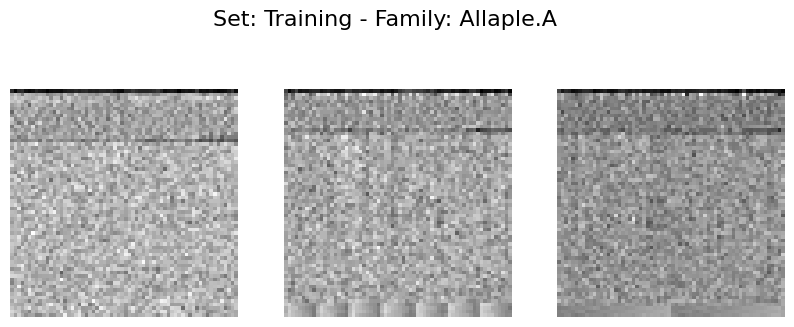

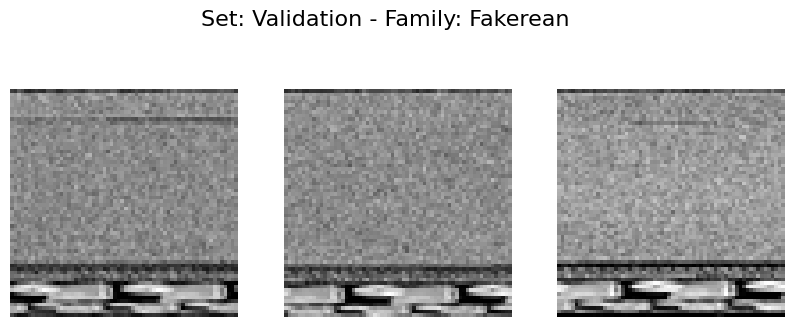

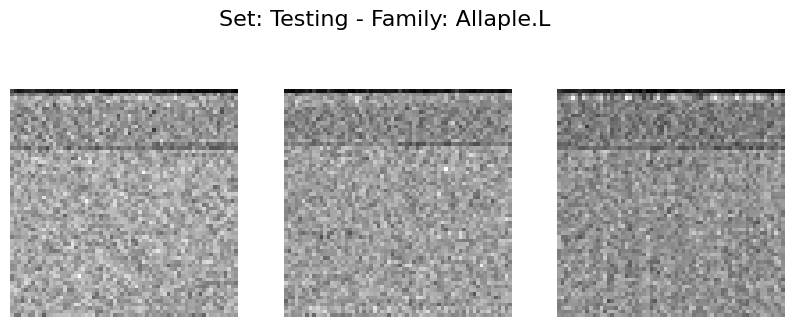

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

def visualize_family(family_name, set_name):
    """Loads and displays 3 random images from a given family."""
    path = os.path.join("malimg_resized", family_name)
    image_files = random.sample(os.listdir(path), 3)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f"Set: {set_name} - Family: {family_name}", fontsize=16)
    for i, img_file in enumerate(image_files):
        img = Image.open(os.path.join(path, img_file))
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()

# --- Pick one family from each of your sets ---
training_family_sample = "Allaple.A" # From your training set
validation_family_sample = "Fakerean" # From your validation set
testing_family_sample = "Allaple.L" # From your testing set

visualize_family(training_family_sample, "Training")
visualize_family(validation_family_sample, "Validation")
visualize_family(testing_family_sample, "Testing")